In [424]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from multiprocessing import Pool

import utils.lifesense_utils as ls_utils

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

%matplotlib inline

# Load Data

## External data and sources

### Coronavirus cases

- https://ourworldindata.org/coronavirus-source-data
- https://github.com/CSSEGISandData/COVID-19

In [650]:
covid_file_loc = "/home/tliu/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
covid_confirmed_df = pd.read_csv(covid_file_loc)

In [651]:
def build_covid_ts(df, col_name):
    """Builds a timeseries data frame with the given df and column name"""
    df = df.reset_index(drop=True)
    
    ts = df[df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]].sum()
    ts.index.name = 'date'
    ts  = ts.rename(col_name)
    ts = ts.to_frame().reset_index()
    ts['date'] = pd.to_datetime(ts['date'])
    return ts

#### US

In [652]:
covid_us_df = covid_confirmed_df[(covid_confirmed_df['Country/Region'] == 'US')]
# filter out cities
#covid_us = covid_us[~(covid_us['Province/State'].str.contains(','))]
covid_us_df = covid_us_df.reset_index(drop=True)

In [653]:
covid_us_ts = build_covid_ts(covid_us_df, "us_confirmed_cases")

In [654]:
covid_us_ts.tail()

,date,us_confirmed_cases
55,2020-03-17,6421
56,2020-03-18,7783
57,2020-03-19,13677
58,2020-03-20,19100
59,2020-03-21,25489


#### Global

In [655]:
covid_world_ts = build_covid_ts(covid_confirmed_df, "global_confirmed_cases")

### Stock market

- **S&P 500**: [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history/)

In [656]:
sp500_file_loc = "/home/tliu/covid-anxiety/data/^GSPC.csv"
sp500_df = pd.read_csv(sp500_file_loc)
#sp500_df[sp500_df['Date'] >= '2020-01-01']
sp500_df['date'] = pd.to_datetime(sp500_df['Date'])
sp500_df['sp500_close'] = sp500_df['Close']

In [657]:
sp500_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,date,sp500_close
246,2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7781540000,2020-03-16,2386.129883
247,2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8358500000,2020-03-17,2529.189941
248,2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8755780000,2020-03-18,2398.100098
249,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2020-03-19,2409.389893
250,2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9044690000,2020-03-20,2304.919922


## Demographics

In [649]:
path = "/home/tliu/lifesense/wave2_data/LS_Wave2_REDCap_scbl_wk1_4_032120.xlsx"

demo_df = pd.read_excel(path, sheet_name=0, dtype={'zipcode': str})
mapping_df = pd.read_excel(path, sheet_name=2, dtype={'case_number': str, 'app_id': str})

## EMA

In [703]:
pids = []
wave2_id_file_loc = "/home/tliu/lifesense/wave2_data/wave2_wk4_ids.txt"
with open(wave2_id_file_loc, "r") as wave_f:
    for line in wave_f.readlines():
        pids.append(line.strip())

In [704]:
keep_cols = ['data_source', 'distracted', 'energetic', 'stress', 'mood', 'for_yesterday', 'generator', 'generator-id', 'pid', 'source', 'timestamp', 'timezone', 'timezone-offset']

In [705]:
ema_file_loc = "/data/tliu/wave2_aggregate/2020-03-22/{}_ema/{}.df"

time_of_days = ['morning', 'afternoon', 'evening']

ema_df = pd.DataFrame()
for pid in pids:
    for tod in time_of_days:
        df = pd.read_pickle(ema_file_loc.format(tod, pid))
        if df.shape[0] > 0:
            df = df[keep_cols]
            #df['time_of_day'] = tod
            ema_df = ema_df.append(df, sort=True)

In [706]:
ema_df.shape

(4320, 13)

### Clean EMA

In [707]:
# format time
ema_df = ls_utils.format_time(ema_df)
# format EMAs
ema_cols = ['stress', 'mood', 'energetic', 'distracted']
ema_df[ema_cols] = ema_df[ema_cols].astype(float)

In [708]:
# correct for_yesterday
grouped = ema_df.groupby(['pid', 'date'], as_index=False)['mood'].count()
print(grouped['mood'].std())
#display(ema_df[ema_df['for_yesterday'] == True][['pid', 'date']].head())
ema_df.loc[ema_df['for_yesterday'] == True, 'date'] = ema_df[ema_df['for_yesterday']]['date'] - pd.Timedelta(1, unit='D')
grouped = ema_df.groupby(['pid', 'date'], as_index=False)['mood'].count()
print(grouped['mood'].std())
#display(ema_df[ema_df['for_yesterday'] == True][['pid', 'date']].head())

0.8846033284387749
0.7734247789991838


In [709]:
# take daily mean of stress, mood, energetic, distracted for each partcipant
daily_ema_df = ema_df.groupby(['pid', 'date'], as_index=False)[emas].mean()

,pid,date,stress,mood,energetic,distracted
0,01515998,2020-02-11,4.000000,4.000000,4.000000,4.000000
1,01515998,2020-02-12,4.333333,3.750000,3.666667,3.666667
2,01515998,2020-02-13,4.000000,4.000000,2.750000,4.000000
3,01515998,2020-02-14,4.000000,4.500000,3.500000,4.500000
4,01515998,2020-02-15,4.333333,4.666667,3.666667,4.666667
5,01515998,2020-02-16,5.000000,5.500000,4.000000,4.000000
6,01515998,2020-02-17,3.000000,3.500000,3.000000,3.500000
7,01515998,2020-03-03,4.000000,4.000000,4.000000,4.000000
8,01515998,2020-03-04,4.000000,3.666667,2.000000,4.000000
9,01515998,2020-03-05,3.500000,3.500000,3.000000,4.000000


In [710]:
# take average across individuals
print(daily_ema_df['date'].value_counts())
ts_daily_df = ema_df.groupby(['date'], as_index=False)[emas].mean()

2020-03-04    130
2020-03-06    129
2020-03-07    128
2020-03-08    128
2020-02-14    127
2020-03-03    126
2020-02-12    125
2020-02-16    125
2020-03-05    124
2020-03-09    124
2020-02-15    123
2020-02-17    122
2020-02-13    121
2020-02-11    121
Name: date, dtype: int64


In [711]:
daily_ema_df['date'].unique()

array(['2020-02-11T00:00:00.000000000', '2020-02-12T00:00:00.000000000',
       '2020-02-13T00:00:00.000000000', '2020-02-14T00:00:00.000000000',
       '2020-02-15T00:00:00.000000000', '2020-02-16T00:00:00.000000000',
       '2020-02-17T00:00:00.000000000', '2020-03-03T00:00:00.000000000',
       '2020-03-04T00:00:00.000000000', '2020-03-05T00:00:00.000000000',
       '2020-03-06T00:00:00.000000000', '2020-03-07T00:00:00.000000000',
       '2020-03-08T00:00:00.000000000', '2020-03-09T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [712]:
start_date = '2020-02-01'
end_date = '2020-03-13'

In [713]:
impute_df = daily_ema_df.copy()
for date in pd.date_range(start=start_date, end=end_date):
    if daily_ema_df[daily_ema_df['date'] == date].shape[0] == 0:
        print(date)
        empty = pd.Series(index=daily_ema_df.columns)
        empty['date'] = date
        impute_df = impute_df.append(empty, ignore_index=True)

2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-08 00:00:00
2020-02-09 00:00:00
2020-02-10 00:00:00
2020-02-18 00:00:00
2020-02-19 00:00:00
2020-02-20 00:00:00
2020-02-21 00:00:00
2020-02-22 00:00:00
2020-02-23 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-26 00:00:00
2020-02-27 00:00:00
2020-02-28 00:00:00
2020-02-29 00:00:00
2020-03-01 00:00:00
2020-03-02 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00


In [714]:
impute_df = impute_df.fillna(impute_df.mean())


In [715]:
daily_ema_df = daily_ema_df.fillna(np.inf)

In [716]:
daily_ema_df.to_pickle("/home/tliu/covid-anxiety/data/daily_ema.df")

## PHQ

In [674]:
keep_cols = ['data_source',  
    'pleasure',
    'depression',
    'sleep',
    'energy',
    'appetite',
    'feeling-bad',
    'concentration',
    'movement',
    #'difficulty',
    'generator', 'generator-id', 'pid', 'source', 'timestamp', 'timezone', 'timezone-offset']

In [676]:
phq_file_loc = "/data/tliu/wave2_aggregate/2020-03-22/{}_phq8/{}.df"

time_of_days = ['morning', 'evening']

phq_df = pd.DataFrame()
for pid in pids:
    for tod in time_of_days:
        df = pd.read_pickle(phq_file_loc.format(tod, pid))
        if df.shape[0] > 0:
            df = df[keep_cols]
            #df['time_of_day'] = tod
            phq_df = phq_df.append(df, sort=True)
            #break
    #break

In [677]:
phq_df.columns

Index(['appetite', 'concentration', 'data_source', 'depression', 'energy',
       'feeling-bad', 'generator', 'generator-id', 'movement', 'pid',
       'pleasure', 'sleep', 'source', 'timestamp', 'timezone',
       'timezone-offset'],
      dtype='object')

In [678]:
phq_cols = [
    'pleasure',
    'depression',
    'sleep',
    'energy',
    'appetite',
    'feeling-bad',
    'concentration',
    'movement'
]

In [679]:
phq_df = ls_utils.format_time(phq_df)
phq_df[phq_cols] = phq_df[phq_cols].astype(int)

In [680]:
phq_df['phq_tot'] = phq_df[phq_cols].sum(axis=1)

## Semantic Location Labels

In [163]:
def extract_slocs(row, loc_attr, max_nbr):
    """extracts semantic location information from each row"""
    loc_df = pd.DataFrame()
    for i in range(max_nbr):
        # check for lat/long
        lat = "place-latitude-{}".format(i)
        if not pd.isnull(row[lat]):
            # we have a valid row
            row_dict = {}
            # populate metadata
            for col in keep_cols:
                row_dict[col] = row[col]
            # populate location attributes
            for attr in loc_attr:
                attr_name = "{}-{}".format(attr, i) 
                if attr_name in row.index and not pd.isnull(row[attr_name]):
                    row_dict[attr] = row[attr_name]
                else:
                    row_dict[attr] = np.nan
            series = pd.Series(row_dict)
            #print(series)
            loc_df = loc_df.append(series, ignore_index=True)
    return loc_df    

In [169]:
even_file_loc = "/data/tliu/wave2/evening_ema/{}.df"
keep_cols = ['source', 'timestamp', 'timezone-offset', 'data_source', 'date']

even_ema_df = pd.DataFrame()
for pid in pids:
    df = pd.read_pickle(even_file_loc.format(pid))
    if df.shape[0] > 0:
        sel_cols = df.columns[df.columns.isin(keep_cols) | df.columns.str.startswith("place")]
        sel_df = df[sel_cols]
        even_ema_df = even_ema_df.append(sel_df, sort=True)
        #print(even_ema_df.shape)

In [170]:
even_ema_df = ls_utils.format_time(even_ema_df)

In [171]:
cols = list(even_ema_df.columns[even_ema_df.columns.str.startswith('place')].values)
# remove trailing numbering
attributes = ['-'.join(col.split('-')[:-1]) for col in cols]
attributes = list(set(attributes))

In [172]:
nbrs = [int(col.split('-')[-1]) for col in cols]
max(nbrs)

13

In [173]:
%%time

semantic_locs = pd.DataFrame()
for i, row in even_ema_df.iterrows():
    df = extract_slocs(row, attributes, 14)
    semantic_locs = semantic_locs.append(df)

CPU times: user 17.7 s, sys: 12.2 ms, total: 17.7 s
Wall time: 17.7 s


In [184]:
even_phq_file_loc = "/data/tliu/wave2/evening_phq8/{}.df"
keep_cols = ['source', 'timestamp', 'timezone-offset', 'data_source', 'date']

even_phq_df = pd.DataFrame()
for pid in pids:
    df = pd.read_pickle(even_phq_file_loc.format(pid))
    if df.shape[0] > 0:
        sel_cols = df.columns[df.columns.isin(keep_cols) | df.columns.str.startswith("place")]
        sel_df = df[sel_cols]
        even_phq_df = even_phq_df.append(sel_df, sort=True)
        #print(even_phq_df.shape)

In [185]:
even_phq_df = ls_utils.format_time(even_phq_df)

In [186]:
cols = list(even_phq_df.columns[even_phq_df.columns.str.startswith('place')].values)
# remove trailing numbering
attributes = ['-'.join(col.split('-')[:-1]) for col in cols]
attributes = list(set(attributes))

In [187]:
nbrs = [int(col.split('-')[-1]) for col in cols]
max(nbrs)

13

In [188]:
%%time

semantic_phq_locs = pd.DataFrame()
for i, row in even_phq_df.iterrows():
    df = extract_slocs(row, attributes, 14)
    semantic_phq_locs = semantic_phq_locs.append(df)

CPU times: user 5.86 s, sys: 9.99 ms, total: 5.87 s
Wall time: 5.88 s


In [189]:
semantic_locs.shape

(2447, 14)

In [190]:
semantic_phq_locs.shape

(526, 14)

In [191]:
semantic_locs = semantic_locs.append(semantic_phq_locs)
semantic_locs = semantic_locs.sort_values(by=['source', 'date'])

In [192]:
semantic_locs.shape
semantic_locs['place-kind'].value_counts()

Home                                                       1120
Work                                                        401
Food and Drink                                              217
Shopping                                                    202
Another Person's Home                                       184
I Was Not There                                             167
Errand                                                      163
Other…                                                      135
Entertainment                                                85
Medical/Dentist/Mental Health                                82
Commute/Travel (Airport, Bus Stop, Train Station, Etc.)      79
Gym/Exercise                                                 37
Walking                                                      33
Education                                                    32
Place of Worship (Church, Temple, Etc.)                      19
Beauty/Grooming                         

In [193]:
semantic_locs['pid'] = semantic_locs['source']

In [194]:
semantic_locs.to_pickle("/home/tliu/covid-anxiety/data/slocs.df")

## Semantic Location

In [681]:
all_sloc = pd.read_pickle("/home/tliu/covid-anxiety/data/sloc_hr.df")
all_sloc['date'] = all_sloc['hr'].dt.floor('d')

sloc_dur_cols = list(all_sloc.columns[all_sloc.columns.str.endswith('dur')])

In [682]:
all_sloc[sloc_dur_cols].describe()

,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,shopping_dur,errand_dur,health_dur,education_dur,entertainment_dur,other_dur,n/a_dur
count,134609.000000,134609.000000,134609.000000,134609.000000,134609.000000,134609.000000,134609.000000,134609.00000,134609.000000,134609.000000,134609.000000,134609.000000,134609.000000,134609.000000
mean,57.167010,1917.795913,213.022576,3.529140,76.617039,3.821854,27.849334,14.85917,32.830205,8.862253,11.920563,6.756309,69.873277,238.269128
std,406.781467,1633.605263,794.304219,94.367665,486.234955,103.721460,298.066621,181.78586,308.292530,155.019420,191.594131,139.616984,451.146052,755.709765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3421.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3600.000000,3600.000000,3600.000000,3599.000000,3600.000000,3598.000000,3600.000000,3600.00000,3600.000000,3600.000000,3600.000000,3599.000000,3600.000000,3600.000000


In [783]:
#all_sloc[sloc_dur_cols] = all_sloc[sloc_dur_cols].clip(0, 100000000)
sloc_daily = all_sloc.groupby(['pid', 'date']).sum()
sloc_daily = sloc_daily.reset_index()

display(sloc_daily.head())

,pid,date,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,shopping_dur,...,n/a_anothers_home,n/a_religion,n/a_travel,n/a_shopping,n/a_errand,n/a_health,n/a_education,n/a_entertainment,n/a_other,tot_tansitions
0,01515998,2020-02-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,01515998,2020-02-10,0.0,1964.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,2,10
2,01515998,2020-02-11,1221.0,10737.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,3,26
3,01515998,2020-02-12,4793.0,27676.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,21
4,01515998,2020-02-13,0.0,16472.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,31


### Sandbox

In [786]:
sloc_daily[sloc_daily['date'] == '2020-02-05']#[['pid', 'tot_duration']]

,pid,date,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,shopping_dur,...,n/a_anothers_home,n/a_religion,n/a_travel,n/a_shopping,n/a_errand,n/a_health,n/a_education,n/a_entertainment,n/a_other,tot_tansitions
224,05498364,2020-02-05,0.0,3924.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
666,14456223,2020-02-05,0.0,5938.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
713,14673820,2020-02-05,1957.0,0.0,22683.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,8
759,15266887,2020-02-05,0.0,11692.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
896,18273257,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1110,22425521,2020-02-05,0.0,28231.0,1242.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,6
1234,23255906,2020-02-05,0.0,43857.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1280,24390140,2020-02-05,0.0,21740.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
1846,31651056,2020-02-05,0.0,0.0,0.0,0.0,15404.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2391,41532020,2020-02-05,0.0,10485.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [792]:
dur_cols = sloc_daily.columns[sloc_daily.columns.str.endswith('dur')]
sloc_daily['tot_duration'] = sloc_daily[dur_cols].sum(axis=1)
sloc_daily.groupby('date')['tot_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2020-02-04,3.0,18508.666667,6618.218970,13667.0,14738.00,15809.0,20929.50,26050.0
2020-02-05,19.0,20046.210526,18642.926021,3518.0,7569.00,11412.0,28112.00,74107.0
2020-02-06,72.0,36866.930556,24452.914883,0.0,15499.00,33266.5,52931.00,83094.0
2020-02-07,101.0,52049.069307,28703.789752,0.0,28253.00,62661.0,78514.00,83783.0
2020-02-08,111.0,57704.324324,27999.674906,0.0,44565.50,73002.0,79222.50,82916.0
2020-02-09,118.0,55604.050847,31326.304821,0.0,26799.25,72657.0,79977.00,83449.0
2020-02-10,123.0,59105.886179,28852.919569,0.0,47236.00,73580.0,80397.00,82452.0
2020-02-11,128.0,60553.296875,26831.807790,0.0,50649.25,74446.5,80412.00,82989.0
2020-02-12,128.0,63385.929688,26686.089879,0.0,49905.25,77803.0,81285.75,83302.0


In [789]:
sloc_daily['tot_duration'].describe()

count     5728.000000
mean     63055.052025
std      28440.792345
min          0.000000
25%      54914.000000
50%      78784.500000
75%      81592.000000
max      84952.000000
Name: tot_duration, dtype: float64

## Location

In [645]:
%%time

fus_loc = "/data/tliu/wave2_aggregate/2020-03-22/pdk-location"
fus_args = [(pid, fus_loc) for pid in pids]

with Pool(12) as pool:
    fus_results = pool.starmap(ls_utils.build_fus, fus_args)

29504072
(1153, 18)
96968904
(9215, 18)
14456223
(9802, 18)
92656094
(10657, 18)
88666137
(10775, 18)
14673820
(9836, 18)
21517496
(8287, 18)
15266887
43521459
(10327, 18)
(9764, 18)
05348360
(9657, 18)
94758398
79755032
(10806, 18)
(10093, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/l

37057080
(11471, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



03925638
(11254, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



26222720
(7951, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



68460425
(8747, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



69045373
69820876
(10847, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



99558567
(11504, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



16052899
(2980, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



01515998
(7780, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



98724064
(10923, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



96819556
(276, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



86209099
(10779, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



55300032
(9750, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



68526739
(10159, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



41532020
(11883, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



38070362
(7715, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



05498364
(5275, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



78980081
(11066, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



22425521
(9935, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



20841577
(1364, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



84821824
(6742, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



43080203
(10872, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



22584726
(5106, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



13195321
(7261, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



16241706
(10555, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



83857691
(9947, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



46177605
(11950, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



56525162
(4, 16)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



07919808
(293, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



04229942
(10410, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



84995481
(8740, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



26192608
(7982, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



94193380
(9839, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



27318176
(8985, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



24390140
(5240, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



23255906
(11557, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



38300374
(10205, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



18273257
(2622, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



68154736
(4968, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



51287973
(1747, 15)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



71526997
(11166, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



84966718
(8750, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



75406227
(9270, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



27410219
(7728, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



90730909
(7582, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



98287414
(10825, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



70226916
(8613, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



60827000
(10287, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



24458423
(10833, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



60975479
(9567, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



32454300
(2134, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



28749524
(11918, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



16899237
(1087, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



59655460
(5630, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



22775534
(9037, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



28218945
73771763
(11400, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



95932094
(5729, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



62043543
(2580, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



82450932
(10295, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



73062896
(6066, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



26603492
(12432, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



47537499
(10512, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



37998680
(6544, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



04045315
(1020, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



13229365
(12319, 18)
39742047
(8834, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



67141200
(9504, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



58535318
(11947, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



51034018
(4145, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



29486061
(4629, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



99527269
(9248, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



56462129
(9098, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



64117655
73715015
(6291, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



88503521
(9234, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



56227303
(10251, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



59984371
(10419, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



28506000
(10667, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



60640743
(12442, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



31651056
(552, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



10834985
(3816, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



57478615
(8519, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



37329817
(11320, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



24778662
(11266, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



58517740
(9894, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



75306774
(5187, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



48639153
(7755, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



02334954
(10258, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



35277842
(10551, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



69225096
(8844, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



75628425
(10694, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



57626776
(5045, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



50163904
(11546, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



77117954
(7784, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



62731236
(9678, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



19791641
(1460, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



06281053
(9595, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



75414421
(10535, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



70282034
(7269, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



21279610
(106, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



53832570
(190, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



86844402
(8524, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



07981456
(9956, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



62895808
(11559, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



08818533
(5214, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



63369098
(11930, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



66336713
(11695, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



67550541
(6005, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



61157154
(4982, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/l

30890949
(12085, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



44641942
(10622, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



13448173
(10353, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



61398362
(10027, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



72658579
(89, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



49958619
(6507, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



34031533
(10238, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



69428308
(6406, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



39666729
(964, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



55993116
(7783, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



91484040
(8398, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



37841008
(10159, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

invalid value encountered in log



06067864
(7351, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



78639189
(11378, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



50960850
(7703, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



35538681
(8749, 18)


/home/tliu/lifesense/utils/lifesense_utils.py:150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log

/home/tliu/lifesense/utils/lifesense_utils.py:183: RuntimeWarning:

divide by zero encountered in log



CPU times: user 4.5 s, sys: 2.79 s, total: 7.29 s
Wall time: 2h 6min 12s


In [646]:
fus_df = pd.DataFrame()

for df in fus_results:
    fus_df = fus_df.append(df)
fus_df.head()

,pid,date,dist,entropy,norm_entropy,cluster,loc_var,velocity
0,14673820,2020-02-04,11.996581,0.071730,0.016369,80,-4.924435,2.501951
1,14673820,2020-02-05,66.322543,1.496809,0.341579,80,-4.924435,4.414840
2,14673820,2020-02-06,54.978973,0.476409,0.108719,80,-4.924435,1.877966
3,14673820,2020-02-07,71.376751,1.374433,0.313652,80,-4.924435,3.113240
4,14673820,2020-02-08,23.936474,0.483886,0.110425,80,-4.924435,1.199426


In [647]:
fus_df.shape

(5221, 8)

In [648]:
fus_df.to_pickle("~/covid-anxiety/data/fus_daily.df")

## Communication

- note: completed using feature_pipeline.py

In [687]:
all_cal = pd.read_pickle("~/covid-anxiety/data/cal_hr.df")
all_cal['date'] = all_cal['hour'].dt.floor('d')
cal_daily = all_cal.groupby(['pid', 'date']).sum()
cal_daily = cal_daily.reset_index()
cal_daily["is_wkday"] = (pd.to_datetime(cal_daily['date']).dt.dayofweek < 5).astype(float)


In [688]:
all_sms = pd.read_pickle("~/covid-anxiety/data/sms_hr.df")
all_sms['date'] = all_sms['hour'].dt.floor('d')
sms_daily = all_sms.groupby(['pid', 'date']).sum()
sms_daily = sms_daily.reset_index()


In [689]:
sms_daily.head()

,pid,date,tot_sms_count,tot_sms_length,in_sms_count,in_sms_length,out_sms_count,out_sms_length
0,01515998,2020-02-02,1,124,0.0,0.0,1.0,124.0
1,01515998,2020-02-03,2,162,2.0,162.0,0.0,0.0
2,01515998,2020-02-04,1,79,1.0,79.0,0.0,0.0
3,01515998,2020-02-05,6,560,4.0,446.0,2.0,114.0
4,01515998,2020-02-06,5,264,4.0,234.0,1.0,30.0


## Combine Phone Data

In [751]:
sloc_minutes = sloc_daily.copy()
sloc_minutes[sloc_dur_cols] = sloc_minutes[sloc_dur_cols] / 60

sloc_pct_cols = [x.split('_')[0] + '_pct' for x in sloc_dur_cols]
for i, col in enumerate(sloc_pct_cols):
    sloc_minutes[col] = sloc_minutes[sloc_dur_cols[i]] / sloc_minutes[sloc_dur_cols].sum(axis=1)

In [752]:
sloc_minutes[sloc_pct_cols].describe()

,food_pct,home_pct,work_pct,exercise_pct,anothers_pct,religion_pct,travel_pct,shopping_pct,errand_pct,health_pct,education_pct,entertainment_pct,other_pct,n/a_pct
count,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000,5225.000000
mean,0.024122,0.688426,0.074736,0.001220,0.029937,0.001360,0.009725,0.005409,0.013889,0.003100,0.004125,0.002426,0.027694,0.113831
std,0.124316,0.338849,0.168696,0.010032,0.139955,0.013228,0.089717,0.027140,0.092083,0.023366,0.038195,0.026617,0.135701,0.210245
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.527880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.808718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037662
75%,0.000000,0.990004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121914
max,1.000000,1.000000,1.000000,0.189405,1.000000,0.323878,1.000000,0.934012,1.000000,0.457186,0.966737,0.973888,1.000000,1.000000


In [753]:
sloc_minutes = sloc_minutes[['pid', 'date'] + sloc_dur_cols + sloc_pct_cols]

In [754]:
sloc_minutes.groupby('date')['pid'].nunique()

date
2020-02-04      3
2020-02-05     19
2020-02-06     72
2020-02-07    101
2020-02-08    111
2020-02-09    118
2020-02-10    123
2020-02-11    128
2020-02-12    128
2020-02-13    128
2020-02-14    128
2020-02-15    130
2020-02-16    131
2020-02-17    132
2020-02-18    132
2020-02-19    132
2020-02-20    132
2020-02-21    133
2020-02-22    133
2020-02-23    133
2020-02-24    133
2020-02-25    133
2020-02-26    133
2020-02-27    133
2020-02-28    133
2020-02-29    133
2020-03-01    133
2020-03-02    133
2020-03-03    133
2020-03-04    132
2020-03-05    130
2020-03-06    130
2020-03-07    129
2020-03-08    129
2020-03-09    130
2020-03-10    129
2020-03-11    128
2020-03-12    128
2020-03-13    127
2020-03-14    127
2020-03-15    126
2020-03-16    125
2020-03-17    123
2020-03-18    119
2020-03-19    118
2020-03-20    117
2020-03-21    108
2020-03-22     29
Name: pid, dtype: int64

In [755]:
phone_df = fus_df.copy()
phone_df = phone_df.merge(cal_daily, on=['pid', 'date'], how='left')
phone_df = phone_df.merge(sms_daily, on=['pid', 'date'], how='left')
phone_df = phone_df.merge(daily_ema_df, on=['pid', 'date'], how='left')
phone_df = phone_df.merge(sloc_minutes, on=['pid', 'date'], how='left')
phone_df = phone_df.merge(phq_df[['pid', 'date', 'phq_tot']], on=['pid', 'date'], how='left')

phone_df.head(100)

,pid,date,dist,entropy,norm_entropy,cluster,loc_var,velocity,tot_call_count,tot_call_duration,...,religion_pct,travel_pct,shopping_pct,errand_pct,health_pct,education_pct,entertainment_pct,other_pct,n/a_pct,phq_tot
0,14673820,2020-02-04,11.996581,0.071730,0.016369,80,-4.924435,2.501951,511.0,117516.0,...,0.0,0.000000,0.000000,0.897780,0.000000,0.000000,0.000000,0.000000,0.076602,NaN
1,14673820,2020-02-05,66.322543,1.496809,0.341579,80,-4.924435,4.414840,2.0,121.0,...,0.0,0.000000,0.000000,0.177730,0.000000,0.000000,0.000000,0.000000,0.179113,NaN
2,14673820,2020-02-06,54.978973,0.476409,0.108719,80,-4.924435,1.877966,15.0,4526.0,...,0.0,0.000000,0.000000,0.798548,0.000000,0.000000,0.000000,0.000000,0.065273,NaN
3,14673820,2020-02-07,71.376751,1.374433,0.313652,80,-4.924435,3.113240,23.0,2095.0,...,0.0,0.000000,0.000000,0.564209,0.000000,0.000000,0.000000,0.081125,0.090562,NaN
4,14673820,2020-02-08,23.936474,0.483886,0.110425,80,-4.924435,1.199426,3.0,123.0,...,0.0,0.000000,0.000000,0.929587,0.000000,0.000000,0.000000,0.000000,0.070413,NaN
5,14673820,2020-02-09,48.273649,0.284706,0.064971,80,-4.924435,1.636430,11.0,2045.0,...,0.0,0.000000,0.000000,0.914089,0.000000,0.000000,0.000000,0.000000,0.085911,NaN
6,14673820,2020-02-10,64.388705,1.201516,0.274192,80,-4.924435,3.147218,8.0,1266.0,...,0.0,0.000000,0.000000,0.470807,0.000000,0.000000,0.000000,0.000000,0.104041,NaN
7,14673820,2020-02-11,69.610771,1.308128,0.298521,80,-4.924435,2.780241,20.0,1844.0,...,0.0,0.000000,0.000000,0.648895,0.000000,0.000000,0.000000,0.000000,0.067467,NaN
8,14673820,2020-02-12,69.285068,0.981569,0.223999,80,-4.924435,3.801619,11.0,97.0,...,0.0,0.000000,0.000000,0.548841,0.000000,0.000000,0.000000,0.000000,0.088656,NaN
9,14673820,2020-02-13,64.754123,0.772983,0.176399,80,-4.924435,3.459655,16.0,913.0,...,0.0,0.000000,0.000000,0.704437,0.000000,0.000000,0.000000,0.000000,0.073616,NaN


In [756]:
phone_df.columns

Index(['pid', 'date', 'dist', 'entropy', 'norm_entropy', 'cluster', 'loc_var',
       'velocity', 'tot_call_count', 'tot_call_duration', 'is_wkday',
       'tot_sms_count', 'tot_sms_length', 'in_sms_count', 'in_sms_length',
       'out_sms_count', 'out_sms_length', 'stress', 'mood', 'energetic',
       'distracted', 'food_dur', 'home_dur', 'work_dur', 'exercise_dur',
       'anothers_home_dur', 'religion_dur', 'travel_dur', 'shopping_dur',
       'errand_dur', 'health_dur', 'education_dur', 'entertainment_dur',
       'other_dur', 'n/a_dur', 'food_pct', 'home_pct', 'work_pct',
       'exercise_pct', 'anothers_pct', 'religion_pct', 'travel_pct',
       'shopping_pct', 'errand_pct', 'health_pct', 'education_pct',
       'entertainment_pct', 'other_pct', 'n/a_pct', 'phq_tot'],
      dtype='object')

In [757]:
phone_df = phone_df.replace([np.inf, -np.inf], np.nan)

In [758]:
#ema_cols = ['stress', 'mood', 'energetic', 'distracted']
#phone_df[ema_cols] = phone_df[ema_cols].fillna(np.inf)

In [759]:
phone_df['tot_call_duration'] = phone_df['tot_call_duration'] / 60
phone_df = phone_df.fillna(phone_df.mean())

In [760]:
phone_df['velocity'].describe()

count     5248.000000
mean         6.761597
std        189.571709
min          0.000000
25%          0.134614
50%          0.985704
75%          2.924503
max      11833.090372
Name: velocity, dtype: float64

In [761]:
phone_df.to_pickle("/home/tliu/covid-anxiety/data/phone_sensors.df")

## Combine time series data

In [700]:
ts_df = covid_world_ts.copy()
ts_df = ts_df.merge(covid_us_ts, on='date', how='left')
ts_df = ts_df.merge(sp500_df[['date', 'sp500_close']], on='date', how='left')
ts_df.head()

,date,global_confirmed_cases,us_confirmed_cases,sp500_close
0,2020-01-22,555,1,3321.750000
1,2020-01-23,653,1,3325.540039
2,2020-01-24,941,2,3295.469971
3,2020-01-25,1434,2,NaN
4,2020-01-26,2118,5,NaN


In [701]:
ts_df.tail()

,date,global_confirmed_cases,us_confirmed_cases,sp500_close
55,2020-03-17,197142,6421,2529.189941
56,2020-03-18,214910,7783,2398.100098
57,2020-03-19,242708,13677,2409.389893
58,2020-03-20,272166,19100,2304.919922
59,2020-03-21,304524,25489,NaN


In [702]:
ts_df.to_pickle("/home/tliu/covid-anxiety/data/ts.df")

## Processing TODOs

- collect US cases into states and census regions, pull daily reports not time series
- semantic location processing
- evening EMA contact columns
- move extract_slocs to feature_pipeline.py

# Graphs

(array([737460., 737464., 737468., 737472., 737476., 737480., 737484.,
        737485., 737489., 737493., 737497.]),
 <a list of 11 Text xticklabel objects>)

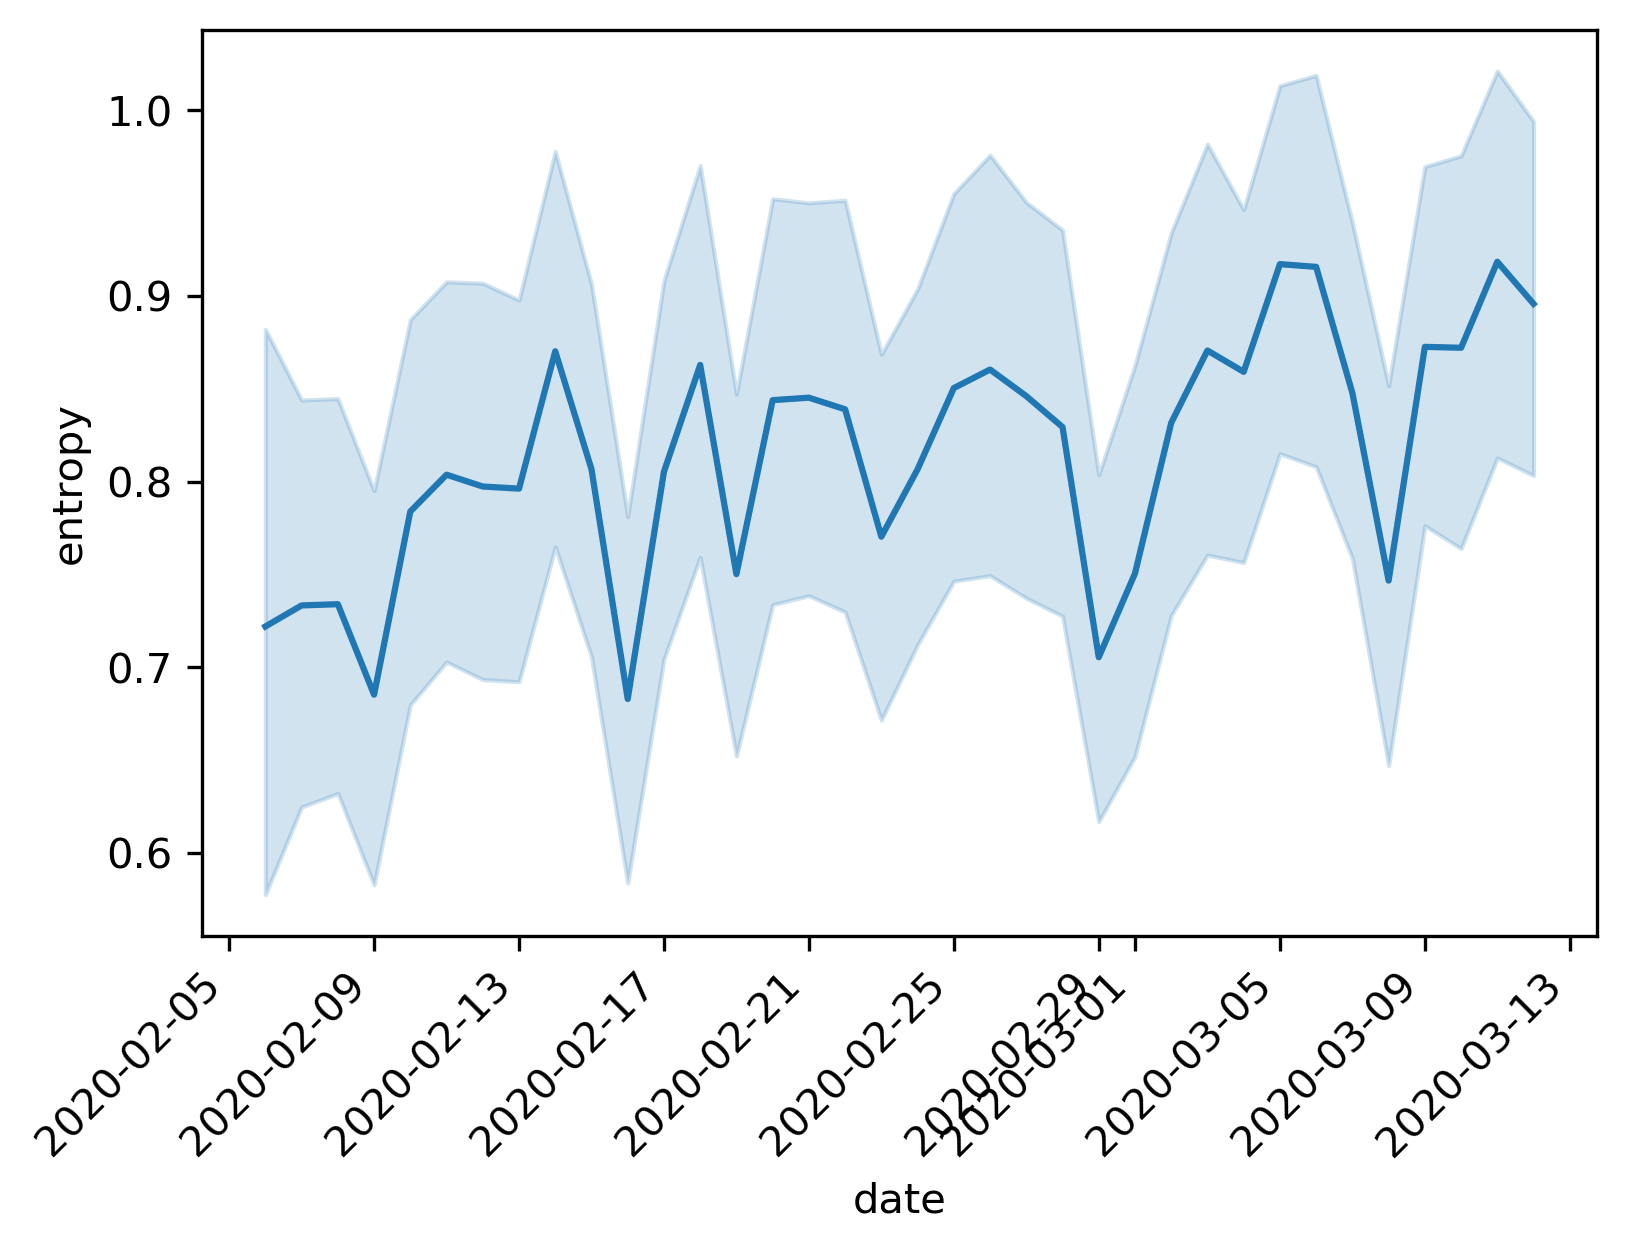

In [329]:
sel_df = fus_df[(fus_df['date'] >= '2020-02-06') & (fus_df['date'] <= '2020-03-12')]
sns.lineplot(x='date', y='entropy', data=sel_df, ci=95)
plt.xticks(rotation=45, ha='right')

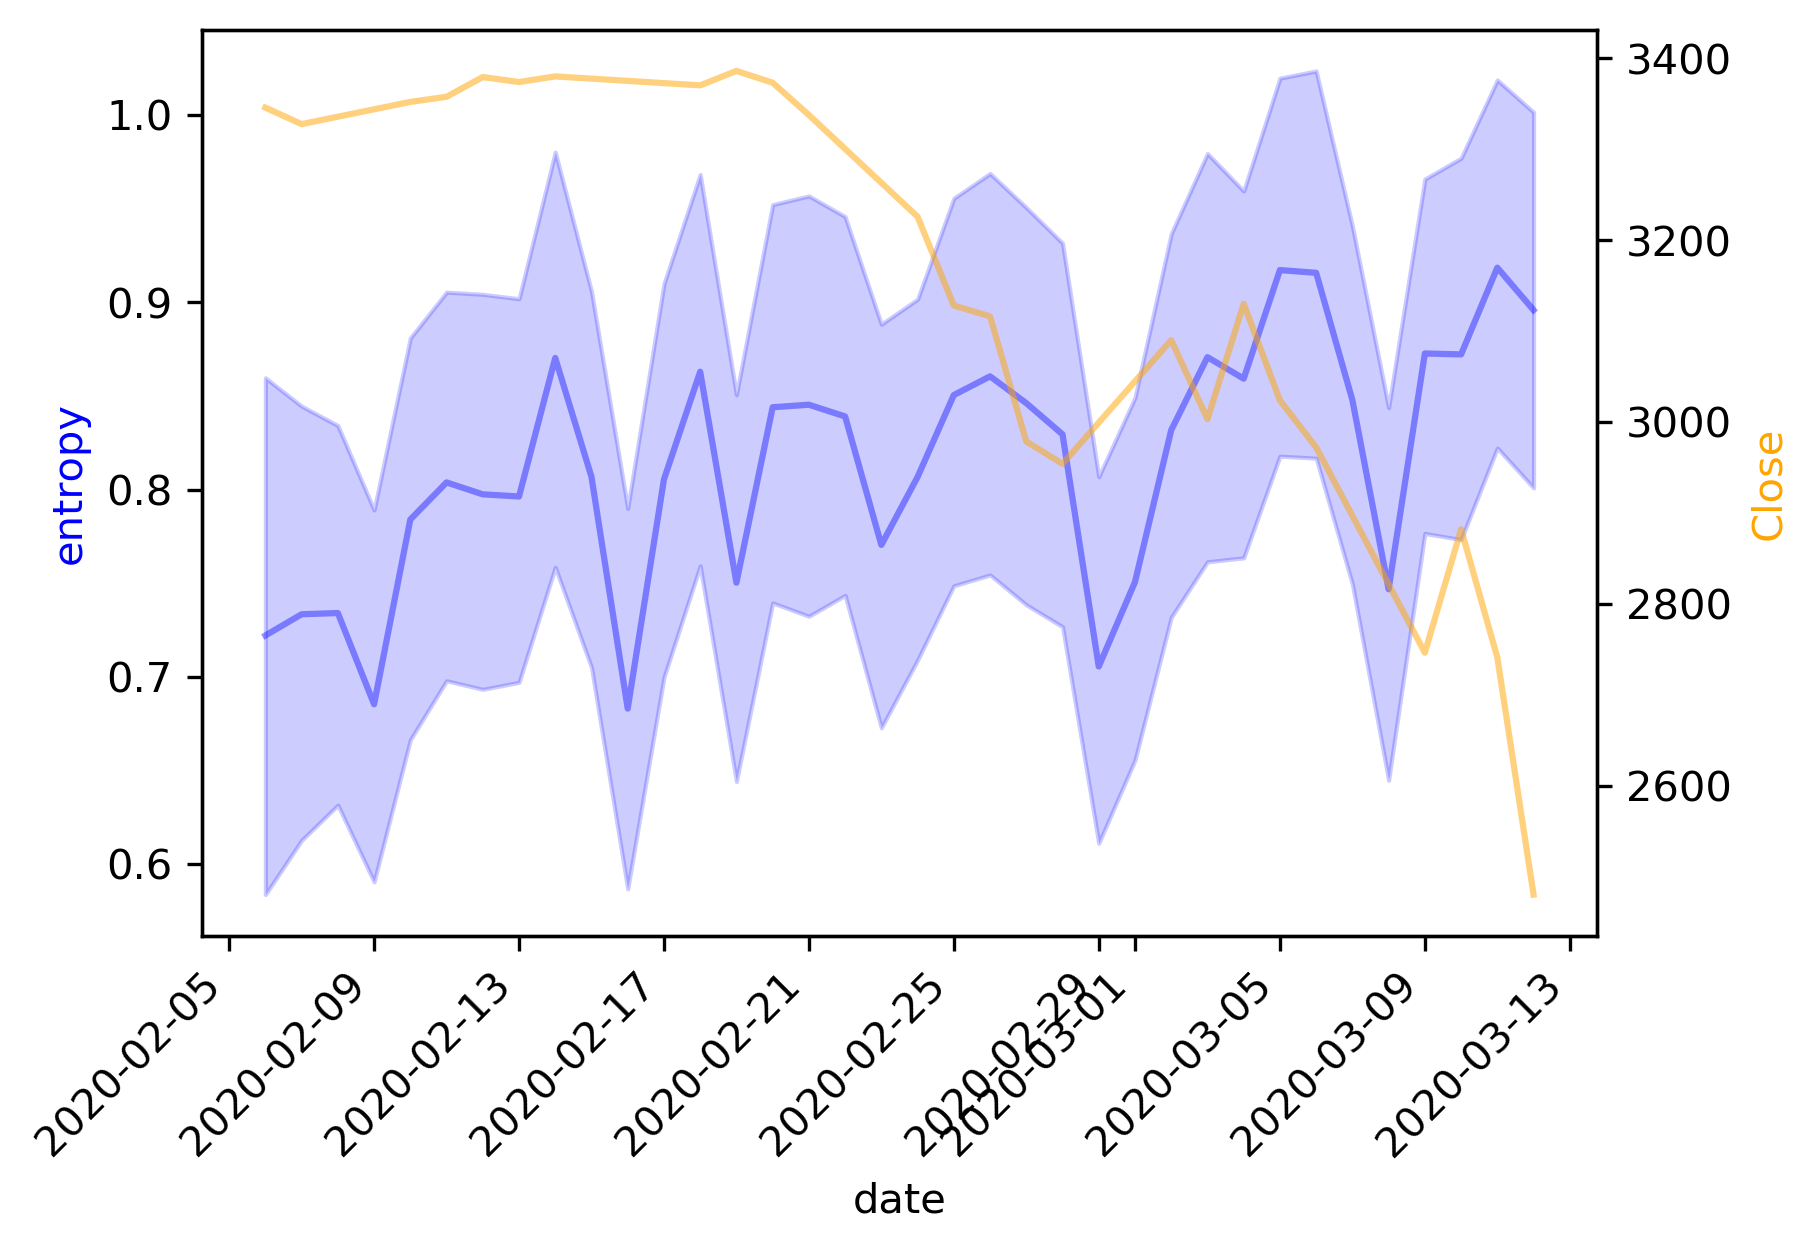

In [379]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
sel_df = fus_df[(fus_df['date'] >= '2020-02-06') & (fus_df['date'] <= '2020-03-12')]
sel_df2 = sp500_df[(sp500_df['date'] >= '2020-02-06') & (sp500_df['date'] <= '2020-03-12')]
p1 = sns.lineplot(x='date', y='entropy', data=sel_df, ax=ax1, alpha=0.4, color='blue')
xticks = ax1.get_xticklabels()
ax1.yaxis.label.set_color("blue")
ax1.set_xticklabels(xticks, rotation=45, ha='right')
p2 = sns.lineplot(x='date', y='Close', data=sel_df2, ax=ax2, alpha=0.5, color='orange')
ax2.yaxis.label.set_color("orange")



In [366]:
impute_df =impute_df.fillna(0)

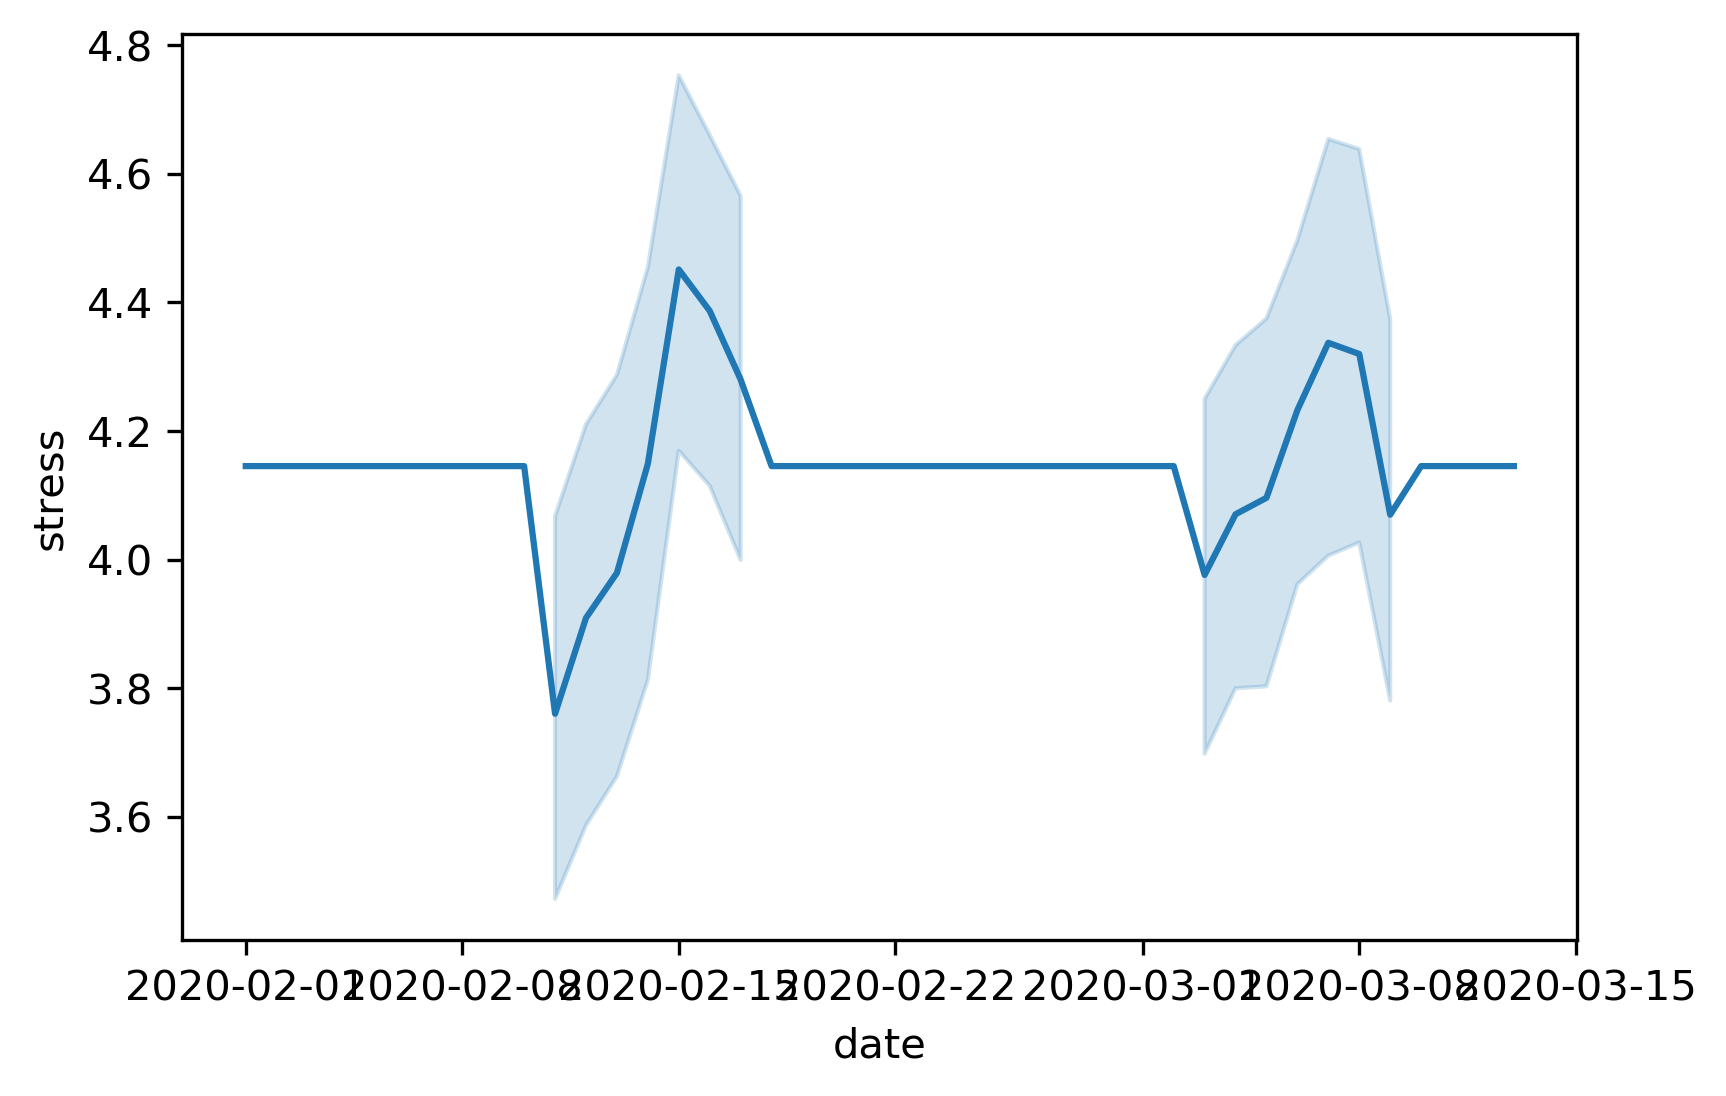

In [377]:
sns.lineplot(x='date', y='stress', data=impute_df)

In [438]:
phone_df['tot_sms_count'].describe()

count    4204.000000
mean       36.143599
std        63.553316
min         0.000000
25%         7.000000
50%        19.000000
75%        37.000000
max      1623.000000
Name: tot_sms_count, dtype: float64

# Sandbox

In [476]:
all_sloc = pd.read_pickle("/home/tliu/covid-anxiety/data/sloc_hr.df")
all_sloc['date'] = all_sloc['hr'].dt.floor('d')

sloc_dur_cols = list(all_sloc.columns[all_sloc.columns.str.endswith('dur')])

In [477]:
all_sloc[sloc_dur_cols].describe()

,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,shopping_dur,errand_dur,health_dur,education_dur,entertainment_dur,other_dur,n/a_dur
count,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000,119457.000000
mean,58.145282,1903.915827,224.081410,3.964004,75.329608,4.272793,27.776740,15.637351,32.786844,9.418678,13.268096,7.556292,72.613166,243.891342
std,410.372198,1635.712020,813.709827,100.125436,481.881855,109.844921,296.933824,187.137608,307.080261,159.791903,202.319268,147.838949,460.222960,763.468608
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3104.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3424.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3600.000000,3600.000000,3600.000000,3599.000000,3600.000000,3598.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3599.000000,3600.000000,3600.000000


In [461]:
all_sloc[all_sloc['food_dur'] < 0][['pid', 'date', 'food_dur', 'hr']]

,pid,date,food_dur,hr
788,77117954,2020-03-10,-458.0,2020-03-10 15:00:00


In [470]:
sloc_test = pd.read_pickle("/data/tliu/wave2_aggregate/semantic-location/77117954.df")
fus_test = pd.read_pickle("/data/tliu/wave2_aggregate/pdk-location/77117954.df")

In [471]:
fus_test = ls_utils.format_time(fus_test)

In [475]:
fus_test.iloc[6950:][['timezone', 'time', 'date', 'hour']]

,timezone,time,date,hour
6950,America/Chicago,2020-03-10 10:36:26,2020-03-10,2020-03-10 10:00:00
6951,America/Chicago,2020-03-10 10:43:35,2020-03-10,2020-03-10 10:00:00
6952,America/Chicago,2020-03-10 10:48:35,2020-03-10,2020-03-10 10:00:00
6953,America/Chicago,2020-03-10 13:41:34,2020-03-10,2020-03-10 13:00:00
6954,America/Chicago,2020-03-10 13:47:22,2020-03-10,2020-03-10 13:00:00
6955,America/Chicago,2020-03-10 13:50:48,2020-03-10,2020-03-10 13:00:00
6956,America/Chicago,2020-03-10 13:58:34,2020-03-10,2020-03-10 13:00:00
6957,America/Chicago,2020-03-10 14:02:45,2020-03-10,2020-03-10 14:00:00
6958,America/Chicago,2020-03-10 14:06:57,2020-03-10,2020-03-10 14:00:00
6959,America/New_York,2020-03-10 15:16:09,2020-03-10,2020-03-10 15:00:00


In [452]:
sloc_test['place-kind'].unique()

array(['Home', nan, 'Food and Drink', 'Shopping', 'Entertainment',
       'Medical/Dentist/Mental Health', 'Work'], dtype=object)

In [455]:
sloc_test[(sloc_test['place-kind'] == 'Food and Drink') & (sloc_test['date'] == '2020-03-10')]

,pid,date,time,latitude,longitude,place-kind
6956,77117954,2020-03-10,2020-03-10 13:58:34,35.2044,-89.7851,Food and Drink
6957,77117954,2020-03-10,2020-03-10 14:02:45,35.2068,-89.7828,Food and Drink
6958,77117954,2020-03-10,2020-03-10 14:06:57,35.2069,-89.7828,Food and Drink
6959,77117954,2020-03-10,2020-03-10 15:16:09,35.2076,-89.7826,Food and Drink
6960,77117954,2020-03-10,2020-03-10 14:20:12,35.2066,-89.7833,Food and Drink
6961,77117954,2020-03-10,2020-03-10 14:21:02,35.2066,-89.7833,Food and Drink
6962,77117954,2020-03-10,2020-03-10 14:26:01,35.1997,-89.7836,Food and Drink


In [464]:
sloc_test.iloc[6950:]#['time'] - sloc_test.iloc[6957]['time']

,pid,date,time,latitude,longitude,place-kind
6950,77117954,2020-03-10,2020-03-10 10:36:26,35.2027,-89.7616,NaN
6951,77117954,2020-03-10,2020-03-10 10:43:35,35.2027,-89.7617,NaN
6952,77117954,2020-03-10,2020-03-10 10:48:35,35.2027,-89.7617,NaN
6953,77117954,2020-03-10,2020-03-10 13:41:34,35.2043,-89.7625,NaN
6954,77117954,2020-03-10,2020-03-10 13:47:22,35.1874,-89.7941,Shopping
6955,77117954,2020-03-10,2020-03-10 13:50:48,35.1874,-89.7944,Shopping
6956,77117954,2020-03-10,2020-03-10 13:58:34,35.2044,-89.7851,Food and Drink
6957,77117954,2020-03-10,2020-03-10 14:02:45,35.2068,-89.7828,Food and Drink
6958,77117954,2020-03-10,2020-03-10 14:06:57,35.2069,-89.7828,Food and Drink
6959,77117954,2020-03-10,2020-03-10 15:16:09,35.2076,-89.7826,Food and Drink


In [ ]:
sloc_test['']

In [459]:
23*60

1380